Disperse entirely with the bluest, redest, and middlest PSFs and plot them against each other to see how they vary.

In [11]:
# General imports
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from astropy.io import fits
from astropy.table import Table, join
import os
os.chdir("/Users/keith/astr/research_astr/roman_grism_sim/ultra_smooth_lambda_dependent/fits")

# Pretty plots
import matplotlib
matplotlib.rcParams["figure.figsize"] = (11,6)
matplotlib.rcParams["image.interpolation"] = "nearest"
matplotlib.rcParams["image.origin"] = "lower"

# Grizli
from grizli.model import GrismFLT

# pysynphot
import pysynphot as S

# WebbPSF
import webbpsf
import webbpsf.roman

In [12]:
# Read SED template; using G0V star template
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

spec = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/ukg0v.dat", format="ascii")
src = S.ArraySpectrum(wave=spec["col1"], flux=spec["col2"], waveunits="angstroms", fluxunits="flam")
src = src.renorm(6, "abmag", bp)
src.convert("flam")

# PSF
wfi = webbpsf.roman.WFI()
# webbpsf.setup_logging("Error")

eff_psf = wfi.calc_psf(monochromatic=(20000 * (10**-10)), fov_pixels=182, oversample=2, source=src)[0].data

psf_direct = np.zeros((4288, 4288))
psf_direct[(2144-182): (2144+182), (2144-182):(2144+182)] = eff_psf

In [13]:
bluest_psf = wfi.calc_psf(monochromatic=(10000 * (10**-10)), fov_pixels=182, oversample=4, source=src)[0].data
redest_psf = wfi.calc_psf(monochromatic=(20000 * (10**-10)), fov_pixels=182, oversample=4, source=src)[0].data
midest_psf = wfi.calc_psf(monochromatic=(15000 * (10**-10)), fov_pixels=182, oversample=4, source=src)[0].data

psf_list = [bluest_psf, midest_psf, redest_psf]

In [14]:
pad = 100
roman = GrismFLT(direct_file="empty_direct.fits", seg_file="empty_seg.fits", pad=pad)

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
empty_direct.fits / Pad ref HDU with 264 pixels
empty_direct.fits / blot segmentation empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [15]:
dispersion_catcher = []

for psf in psf_list:
    direct = np.zeros((4288, 4288))
    direct[(2144-182): (2144+182), (2144-182):(2144+182)] = psf

    # add psf direct image and seg map
    roman.direct.data["SCI"] = direct.astype("float32")
    roman.seg = np.where(roman.direct.data["SCI"], 1, 0).astype("float32")

    single_dispersion = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77, is_cgs=True, store=False,
                                                    in_place=False, spectrum_1d=[src.wave, src.flux])[1]

    dispersion_catcher.append(single_dispersion)

ValueError: could not broadcast input array from shape (728,728) into shape (364,364)

In [ ]:
extraction_catcher = []

for dispersion in dispersion_catcher:
    extraction_max = np.array([dispersion[:, ii].max() for ii in range(dispersion.shape[1])])
    extraction_sum = np.array([dispersion[:, ii].sum() for ii in range(dispersion.shape[1])])
    extraction_catcher.append([extraction_max, extraction_sum])

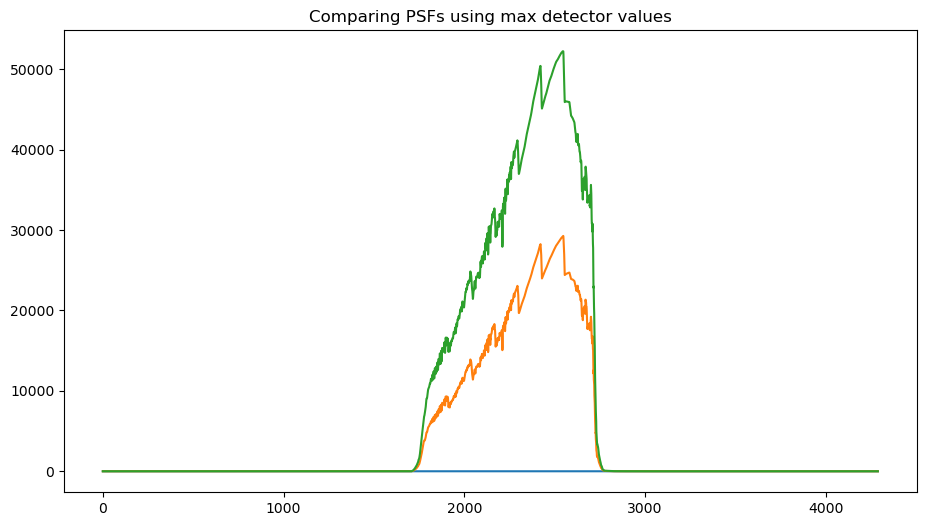

In [ ]:
for extraction in extraction_catcher:
    plt.plot(extraction_catcher[0][0] - extraction[0], label="")

plt.title("Comparing PSFs using max detector values")
plt.show()

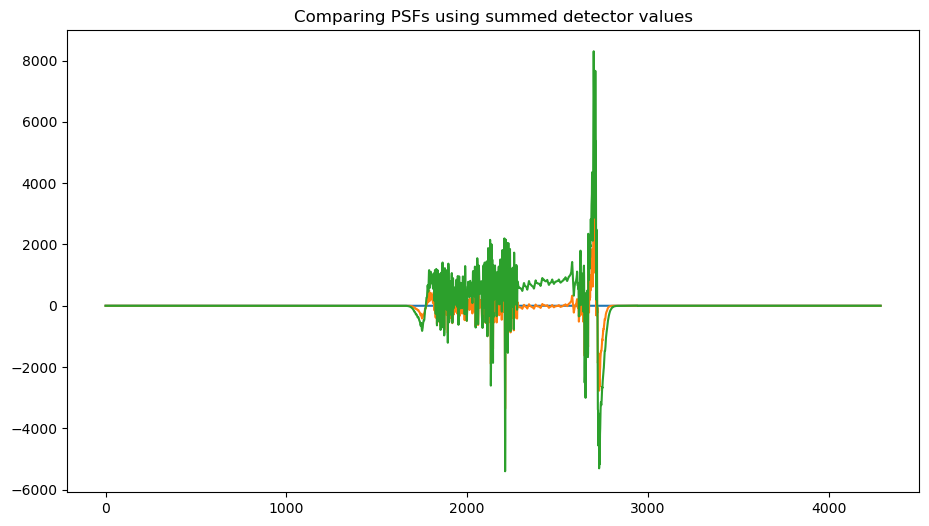

In [ ]:
for extraction in extraction_catcher:
    plt.plot(extraction_catcher[0][1] - extraction[1], label="")

plt.title("Comparing PSFs using summed detector values")
plt.show()